In [1]:
# Set JAX_PLATFORMS=''
import os
# os.environ["JAX_PLATFORMS"] = ""

import jax
import jax.numpy as jnp
import flax
import flax.linen as nn
import json
import wandb
from dataclasses import dataclass, field
from typing import Optional, Dict, Any, Union, Callable, List, Tuple, Type

from flaxdiff.trainer import (
    SimpleTrainer,
    SimpleTrainState,
    TrainState,
    DiffusionTrainer,
)
from flaxdiff.samplers import (
    DiffusionSampler,
)
from flaxdiff.schedulers import (
    NoiseScheduler,
    EDMNoiseScheduler,
    CosineNoiseScheduler,
    KarrasVENoiseScheduler,
)
from flaxdiff.predictors import (
    DiffusionPredictionTransform,
    EpsilonPredictionTransform,
    DirectPredictionTransform,
    VPredictionTransform,
    KarrasPredictionTransform,
)
from flaxdiff.models.common import kernel_init
from flaxdiff.models.simple_unet import Unet
from flaxdiff.models.simple_vit import UViT
from flaxdiff.models.general import BCHWModelWrapper
from flaxdiff.models.autoencoder import AutoEncoder
from flaxdiff.models.autoencoder.diffusers import StableDiffusionVAE
from flaxdiff.inputs import DiffusionInputConfig, ConditionalInputConfig
from flaxdiff.utils import defaultTextEncodeModel, RandomMarkovState
from flaxdiff.samplers.euler import EulerAncestralSampler, EulerSampler
from diffusers import FlaxUNet2DConditionModel

import orbax.checkpoint
from orbax.checkpoint import CheckpointManager, CheckpointManagerOptions, PyTreeCheckpointer

from functools import partial
import warnings
import os

/home/mrwhite0racle/miniconda3/envs/flaxdiff/lib/python3.11/site-packages/torch_xla/__init__.py:251: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
2025-04-19 20:40:11.988308: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745095212.011454 2066084 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745095212.018579 2066084 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745095212.0

In [2]:
import matplotlib.pyplot as plt


def normalizeImage(x): return jax.nn.standardize(x, mean=[127.5], std=[127.5])
def denormalizeImage(x): return (x + 1.0) * 127.5


def plotImages(imgs, fig_size=(8, 8), dpi=100):
    fig = plt.figure(figsize=fig_size, dpi=dpi)
    imglen = imgs.shape[0]
    for i in range(imglen):
        plt.subplot(fig_size[0], fig_size[1], i + 1)
        plt.imshow(jnp.astype(denormalizeImage(imgs[i, :, :, :]), jnp.uint8))
        plt.axis("off")
    plt.show()

In [3]:
def get_wandb_run(wandb_run: str, project, entity):
    """
    Try to get the wandb run for the given experiment name and project.
    Return None if not found.
    """
    import wandb
    wandb_api = wandb.Api()
    # First try to get the run by treating wandb_run as a run ID
    try:
        run = wandb_api.run(f"{entity}/{project}/{wandb_run}")
        print(f"Found run: {run.name} ({run.id})")
        return run
    except wandb.Error as e:
        print(f"Run not found by ID: {e}")
        # If that fails, try to get the run by treating wandb_run as a display name
        # This is a bit of a hack, but it works for now.
        # Note: this will return all runs with the same display name, so be careful.
        print(f"Trying to get run by display name: {wandb_run}")
    runs = wandb_api.runs(path=f"{entity}/{project}", filters={"displayName": wandb_run})
    for run in runs:
        print(f"Found run: {run.name} ({run.id})")
        return run
    return None

def parse_config(config, overrides=None):
    """Parse configuration for inference pipeline.
    
    Args:
        config: Configuration dictionary from wandb run
        overrides: Optional dictionary of overrides for config parameters
        
    Returns:
        Dictionary containing model, sampler, scheduler, and other required components
        including DiffusionInputConfig for the general diffusion framework
    """
    warnings.filterwarnings("ignore")
    
    # Merge config with overrides if provided
    if overrides is not None:
        # Create a deep copy of config to avoid modifying the original
        merged_config = dict(config)
        # Update arguments with overrides
        if 'arguments' in merged_config:
            merged_config['arguments'] = {**merged_config['arguments'], **overrides}
            # Also update top-level config for key parameters
            for key in overrides:
                if key in merged_config:
                    merged_config[key] = overrides[key]
    else:
        merged_config = config
    
    # Parse configuration from config dict
    conf = merged_config
    
    # Setup mappings for dtype, precision, and activation
    DTYPE_MAP = {
        'bfloat16': jnp.bfloat16,
        'float32': jnp.float32,
        'jax.numpy.float32': jnp.float32,
        'jax.numpy.bfloat16': jnp.bfloat16,
        'None': None,
        None: None,
    }
    
    PRECISION_MAP = {
        'high': jax.lax.Precision.HIGH,
        'HIGH': jax.lax.Precision.HIGH,
        'default': jax.lax.Precision.DEFAULT,
        'DEFAULT': jax.lax.Precision.DEFAULT,
        'highest': jax.lax.Precision.HIGHEST,
        'HIGHEST': jax.lax.Precision.HIGHEST,
        'None': None,
        None: None,
    }
    
    ACTIVATION_MAP = {
        'swish': jax.nn.swish,
        'silu': jax.nn.silu,
        'jax._src.nn.functions.silu': jax.nn.silu,
        'mish': jax.nn.mish,
    }
    
    # Get model class based on architecture
    MODEL_CLASSES = {
        'unet': Unet,
        'uvit': UViT,
        'diffusers_unet_simple': FlaxUNet2DConditionModel
    }
    
    # Map all the leaves of the model config, converting strings to appropriate types
    def map_nested_config(config):
        new_config = {}
        for key, value in config.items():
            if isinstance(value, dict):
                new_config[key] = map_nested_config(value)
            elif isinstance(value, list):
                new_config[key] = [map_nested_config(item) if isinstance(item, dict) else item for item in value]
            elif isinstance(value, str):
                if value in DTYPE_MAP:
                    new_config[key] = DTYPE_MAP[value]
                elif value in PRECISION_MAP:
                    new_config[key] = PRECISION_MAP[value]
                elif value in ACTIVATION_MAP:
                    new_config[key] = ACTIVATION_MAP[value]
                elif value == 'None':
                    new_config[key] = None
                elif '.'in value:
                    # Ignore any other string that contains a dot
                    print(f"Ignoring key {key} with value {value} as it contains a dot.")
                else:
                    new_config[key] = value
            else:
                new_config[key] = value
        return new_config

    # Parse architecture and model config
    model_config = conf['model']
        
    # Get architecture type
    architecture = conf.get('architecture', conf.get('arguments', {}).get('architecture', 'unet'))
        
    # Handle autoencoder
    autoencoder_name = conf.get('autoencoder', conf.get('arguments', {}).get('autoencoder'))
    autoencoder_opts_str = conf.get('autoencoder_opts', conf.get('arguments', {}).get('autoencoder_opts', '{}'))
    autoencoder = None
    autoencoder_opts = None
    
    if autoencoder_name:
        print(f"Using autoencoder: {autoencoder_name}")
        if isinstance(autoencoder_opts_str, str):
            autoencoder_opts = json.loads(autoencoder_opts_str)
        else:
            autoencoder_opts = autoencoder_opts_str
            
        if autoencoder_name == 'stable_diffusion':
            print("Using Stable Diffusion Autoencoder for Latent Diffusion Modeling")
            autoencoder_opts = map_nested_config(autoencoder_opts)
            autoencoder = StableDiffusionVAE(**autoencoder_opts)
            
    input_config = conf.get('input_config', None)
    
    # If not provided, create one based on the older format (backward compatibility)
    if input_config is None:
        # Warn if input_config is not provided
        print("No input_config provided, creating a default one.")
        image_size = conf['arguments'].get('image_size', 128)
        image_channels = 3  # Default number of channels
        # Create text encoder
        text_encoder = defaultTextEncodeModel()
        # Create a conditional input config for text conditioning
        text_conditional_config = ConditionalInputConfig(
            encoder=text_encoder,
            conditioning_data_key='text',
            pretokenized=True,
            unconditional_input="",
            model_key_override="textcontext"
        )
        
        # Create the main input config
        input_config = DiffusionInputConfig(
            sample_data_key='image',
            sample_data_shape=(image_size, image_size, image_channels),
            conditions=[text_conditional_config]
        )
    else:
        # Deserialize the input config if it's a string
        input_config = DiffusionInputConfig.deserialize(input_config)
    
    model_kwargs = map_nested_config(model_config)
    
    print(f"Model kwargs after mapping: {model_kwargs}")
    
    model_class = MODEL_CLASSES.get(architecture)
    if not model_class:
        raise ValueError(f"Unknown architecture: {architecture}. Supported architectures: {', '.join(MODEL_CLASSES.keys())}")
    
    # Instantiate the model
    model = model_class(**model_kwargs)
    
    # If using diffusers UNet, wrap it for consistent interface
    if 'diffusers' in architecture:
        model = BCHWModelWrapper(model)
    
    # Create noise scheduler based on configuration
    noise_schedule_type = conf.get('noise_schedule', conf.get('arguments', {}).get('noise_schedule', 'edm'))
    if noise_schedule_type in ['edm', 'karras']:
        # For both EDM and karras, we use the karras scheduler for inference
        noise_schedule = KarrasVENoiseScheduler(1, sigma_max=80, rho=7, sigma_data=0.5)
        prediction_transform = KarrasPredictionTransform(sigma_data=noise_schedule.sigma_data)
    elif noise_schedule_type == 'cosine':
        noise_schedule = CosineNoiseScheduler(1000, beta_end=1)
        prediction_transform = VPredictionTransform()
    else:
        raise ValueError(f"Unknown noise schedule: {noise_schedule_type}")
    
    # Prepare return dictionary with all components
    result = {
        'model': model,
        'model_config': model_kwargs,
        'architecture': architecture,
        'autoencoder': autoencoder,
        'noise_schedule': noise_schedule,
        'prediction_transform': prediction_transform,
        'input_config': input_config,
        'raw_config': conf,
    }
    
    return result

In [9]:
@dataclass
class InferencePipeline:
    """Inference pipeline for a general model."""
    model: nn.Module = None
    state: SimpleTrainState = None
    best_state: SimpleTrainState = None
    
    def from_wandb(
        self,
        wandb_run: str,
        wandb_project: str,
        wandb_entity: str,
    ):
        raise NotImplementedError("InferencePipeline does not support from_wandb.")    
    
def get_latest_checkpoint(checkpoint_path):
    checkpoint_files = os.listdir(checkpoint_path)
    # Sort files by step number
    checkpoint_files = sorted([int(i) for i in checkpoint_files])
    latest_step = checkpoint_files[-1]
    latest_checkpoint = os.path.join(checkpoint_path, str(latest_step))
    return latest_checkpoint

def load_from_checkpoint(
    checkpoint_dir: str,
):
    try:
        checkpointer = PyTreeCheckpointer()
        options = CheckpointManagerOptions(create=False)
        # Convert checkpoint_dir to absolute path
        checkpoint_dir = os.path.abspath(checkpoint_dir)
        manager = CheckpointManager(checkpoint_dir, checkpointer, options)
        ckpt = manager.restore(checkpoint_dir)
        # Extract as above
        state, best_state = None, None
        if 'state' in ckpt:
            state = ckpt['state']
        if 'best_state' in ckpt:
            best_state = ckpt['best_state']
        print(f"Loaded checkpoint from local dir {checkpoint_dir}")
        return state, best_state
    except Exception as e:
        print(f"Warning: Failed to load checkpoint from local dir: {e}")
        return None, None
    
def load_from_wandb_run(
    run,
    project: str,
    entity: str = None,
):
    """
    Loads model from wandb model registry.
    """
    # Get the model version from wandb
    states = None
    config = None
    try:
        if isinstance(run, str):
            run = get_wandb_run(run, project, entity)
        # Search for model artifact
        models = [i for i in run.logged_artifacts() if i.type == 'model']
        if len(models) == 0:
            raise ValueError(f"No model artifacts found in run {run.id}")
        # Pick out any model artifact
        highest_version = max([{'version':int(i.version[1:]), 'name': i.qualified_name} for i in models], key=lambda x: x['version'])
        wandb_modelname = highest_version['name']
        
        print(f"Loading model from wandb: {wandb_modelname} out of versions {[i.version for i in models]}")
        artifact = run.use_artifact(wandb.Api().artifact(wandb_modelname))
        ckpt_dir = artifact.download()
        print(f"Loaded model from wandb: {wandb_modelname} at path {ckpt_dir}")
        # Load the model from the checkpoint directory
        states = load_from_checkpoint(ckpt_dir)
        config = run.config
    except Exception as e:
        print(f"Warning: Failed to load model from wandb: {e}")
    return states, config

def load_from_wandb_registry(
    modelname: str,
    project: str,
    entity: str = None,
    version: str = 'latest',
    registry: str = 'wandb-registry-model',
):
    """
    Loads model from wandb model registry.
    """
    # Get the model version from wandb
    states = None
    config = None
    try:
        artifact = wandb.Api().artifact(f"{registry}/{modelname}:{version}")
        ckpt_dir = artifact.download()
        print(f"Loaded model from wandb registry: {modelname} at path {ckpt_dir}")
        # Load the model from the checkpoint directory
        states = load_from_checkpoint(ckpt_dir)
        run = artifact.logged_by()
        config = run.config
    except Exception as e:
        print(f"Warning: Failed to load model from wandb: {e}")
    return states, config

In [10]:

@dataclass
class DiffusionInferencePipeline(InferencePipeline):
    """Inference pipeline for diffusion models.
    
    This pipeline handles loading models from wandb and generating samples using the
    DiffusionSampler from FlaxDiff.
    """
    state: TrainState = None
    best_state: TrainState = None
    rngstate: Optional[RandomMarkovState] = None
    noise_schedule: NoiseScheduler = None
    model_output_transform: DiffusionPredictionTransform = None
    autoencoder: AutoEncoder = None
    input_config: DiffusionInputConfig = None
    samplers: Dict[Type[DiffusionSampler], Dict[float, DiffusionSampler]] = field(default_factory=dict)
    config: Dict[str, Any] = field(default_factory=dict)
    
    @classmethod
    def from_wandb_run(
        cls,
        wandb_run: str,
        project: str,
        entity: str,
    ):
        """Create an inference pipeline from a wandb run.
        
        Args:
            wandb_run: Run ID or display name
            project: Wandb project name
            entity: Wandb entity name
            wandb_modelname: Model name in wandb registry (if None, loads from checkpoint)
            checkpoint_step: Specific checkpoint step to load (if None, loads latest)
            config_overrides: Optional dictionary to override config values
            checkpoint_base_path: Base path for checkpoint storage
            
        Returns:
            DiffusionInferencePipeline instance
        """
        states, config = load_from_wandb_run(
            wandb_run,
            project=project,
            entity=entity,
        )
            
        if states is None:
            raise ValueError("Failed to load model parameters from wandb.")
        
        state, best_state = states
        parsed_config = parse_config(config)
        
        # Create the pipeline
        pipeline = cls.create(
            config=parsed_config,
            state=state,
            best_state=best_state,
            rngstate=RandomMarkovState(jax.random.PRNGKey(42)),
        )
        return pipeline
    
    @classmethod
    def from_wandb_registry(
        cls,
        modelname: str,
        project: str,
        entity: str = None,
        version: str = 'latest',
        registry: str = 'wandb-registry-model',
    ):
        """Create an inference pipeline from a wandb model registry.
        
        Args:
            modelname: Model name in wandb registry
            project: Wandb project name
            entity: Wandb entity name
            version: Version of the model to load (default is 'latest')
            registry: Registry name (default is 'wandb-registry-model')
            
        Returns:
            DiffusionInferencePipeline instance
        """
        states, config = load_from_wandb_registry(
            modelname=modelname,
            project=project,
            entity=entity,
            version=version,
            registry=registry,
        )
        
        if states is None:
            raise ValueError("Failed to load model parameters from wandb.")
        
        state, best_state = states
        parsed_config = parse_config(config)
        
        # Create the pipeline
        pipeline = cls.create(
            config=parsed_config,
            state=state,
            best_state=best_state,
            rngstate=RandomMarkovState(jax.random.PRNGKey(42)),
        )
        return pipeline
            
    @classmethod
    def create(
        cls,
        config: Dict[str, Any],
        state: Dict[str, Any],
        best_state: Optional[Dict[str, Any]] = None,
        rngstate: Optional[RandomMarkovState] = None,
    ):
        if rngstate is None:
            rngstate = RandomMarkovState(jax.random.PRNGKey(42))
        # Build and return pipeline
        return cls(
            model=config['model'],
            state=state,
            best_state=best_state,
            rngstate=rngstate,
            noise_schedule=config['noise_schedule'],
            model_output_transform=config['prediction_transform'],
            autoencoder=config['autoencoder'],
            input_config=config['input_config'],
            config=config,
        )
    
    def get_sampler(
        self, 
        guidance_scale: float = 3.0,
        sampler_class=EulerAncestralSampler, 
    ) -> DiffusionSampler:
        """Get (or create) a sampler for generating samples.
        
        This method caches samplers by their class and guidance scale for reuse.
        
        Args:
            sampler_class: Class for the diffusion sampler
            guidance_scale: Classifier-free guidance scale (0.0 to disable)
            
        Returns:
            DiffusionSampler instance
        """
        # Get or create dictionary for this sampler class
        if sampler_class not in self.samplers:
            self.samplers[sampler_class] = {}
        
        # Check if we already have a sampler with this guidance scale
        if guidance_scale not in self.samplers[sampler_class]:
            # Create unconditional embeddings if using guidance
            null_embeddings = None
            if guidance_scale > 0.0:
                null_text = self.input_config.conditions[0].get_unconditional()
                null_embeddings = null_text
                print(f"Created null embeddings for guidance with shape {null_embeddings.shape}")
            
            # Create and cache the sampler
            self.samplers[sampler_class][guidance_scale] = sampler_class(
                model=self.model,
                noise_schedule=self.noise_schedule,
                model_output_transform=self.model_output_transform,
                guidance_scale=guidance_scale,
                input_config=self.input_config,
                autoencoder=self.autoencoder,
            )
        
        return self.samplers[sampler_class][guidance_scale]
    
    def generate_samples(
        self,
        num_samples: int,
        resolution: int,
        conditioning_data: Optional[List[Union[Tuple, Dict]]] = None,  # one list per modality or list of tuples
        sequence_length: Optional[int] = None,
        diffusion_steps: int = 50,
        guidance_scale: float = 1.0,
        sampler_class=EulerAncestralSampler,
        timestep_spacing: str = 'linear',
        seed: Optional[int] = None,
        start_step: Optional[int] = None,
        end_step: int = 0,
        steps_override=None,
        priors=None,
        use_best_params: bool = False,
        use_ema: bool = False,
    ):
        # Setup RNG
        rngstate = self.rngstate or RandomMarkovState(jax.random.PRNGKey(seed or 0))
        
        # Get cached or new sampler
        sampler = self.get_sampler(
            guidance_scale=guidance_scale,
            sampler_class=sampler_class,
        )
        if hasattr(sampler, 'timestep_spacing'):
            sampler.timestep_spacing = timestep_spacing
        print(f"Generating samples: steps={diffusion_steps}, num_samples={num_samples}, guidance={guidance_scale}")
        
        if use_best_params:
            state = self.best_state
        else:
            state = self.state
            
        if use_ema:
            params = state['ema_params']
        else:
            params = state['params']
            
             
        return sampler.generate_samples(
            params=params,
            num_samples=num_samples,
            resolution=resolution,
            sequence_length=sequence_length,
            diffusion_steps=diffusion_steps,
            start_step=start_step,
            end_step=end_step,
            steps_override=steps_override,
            priors=priors,
            rngstate=rngstate,
            conditioning=conditioning_data
        )

In [11]:
pipeline = DiffusionInferencePipeline.from_wandb_registry(
    modelname='diffusion-oxford_flowers102-res256',
    project='mlops-msml605-project',
    entity='umd-projects',
)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact diffusion-oxford_flowers102-res256:latest, 1049.57MB. 14 files... 
wandb:   14 of 14 files downloaded.  
Done. 0:0:1.1


Loaded model from wandb registry: diffusion-oxford_flowers102-res256 at path /home/mrwhite0racle/persist/FlaxDiff/artifacts/diffusion-oxford_flowers102-res256:v0


Loaded checkpoint from local dir /home/mrwhite0racle/persist/FlaxDiff/artifacts/diffusion-oxford_flowers102-res256:v0
Using autoencoder: stable_diffusion
Using Stable Diffusion Autoencoder for Latent Diffusion Modeling
Ignoring key dtype with value <class 'jax.numpy.bfloat16'> as it contains a dot.
Scaling factor: 0.18215
Calculating downscale factor...
Downscale factor: 8
Latent channels: 4


Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing FlaxCLIPTextModel: {('vision_model', 'encoder', 'layers', '10', 'self_attn', 'out_proj', 'bias'), ('vision_model', 'encoder', 'layers', '15', 'self_attn', 'q_proj', 'bias'), ('vision_model', 'encoder', 'layers', '20', 'mlp', 'fc2', 'bias'), ('vision_model', 'encoder', 'layers', '20', 'self_attn', 'out_proj', 'bias'), ('vision_model', 'encoder', 'layers', '5', 'self_attn', 'q_proj', 'bias'), ('vision_model', 'encoder', 'layers', '16', 'layer_norm1', 'scale'), ('vision_model', 'encoder', 'layers', '8', 'mlp', 'fc1', 'bias'), ('vision_model', 'encoder', 'layers', '19', 'self_attn', 'q_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '8', 'mlp', 'fc2', 'bias'), ('vision_model', 'encoder', 'layers', '4', 'self_attn', 'v_proj', 'kernel'), ('vision_model', 'encoder', 'layers', '16', 'layer_norm1', 'bias'), ('vision_model', 'encoder', 'layers', '9', 'self_attn', 'k_proj', 'bias'), ('vis

Model kwargs after mapping: {'name': None, 'dtype': <class 'jax.numpy.bfloat16'>, 'precision': None, 'activation': <PjitFunction of <function silu at 0x7f53b3ce4180>>, 'named_norms': False, 'norm_groups': 8, 'emb_features': 256, 'feature_depths': [64, 64, 128, 256, 512], 'num_res_blocks': 2, 'output_channels': 4, 'attention_configs': [None, {'dtype': <class 'jax.numpy.float32'>, 'heads': 8, 'use_projection': False, 'flash_attention': False, 'use_self_and_cross': True}, {'dtype': <class 'jax.numpy.float32'>, 'heads': 8, 'use_projection': False, 'flash_attention': False, 'use_self_and_cross': True}, {'dtype': <class 'jax.numpy.float32'>, 'heads': 8, 'use_projection': False, 'flash_attention': False, 'use_self_and_cross': True}, {'dtype': <class 'jax.numpy.float32'>, 'heads': 8, 'use_projection': False, 'flash_attention': False, 'use_self_and_cross': False}], 'num_middle_res_blocks': 1}


In [ ]:
prompts = [
    'water tulip',
    'a water lily',
    'a water lily',
    'a photo of a rose',
    'a photo of a rose',
    'a water lily',
    'a water lily',
    'a photo of a marigold',
]

samples = pipeline.generate_samples(
    num_samples=len(prompts),
    resolution=256,
    diffusion_steps=100,
    guidance_scale=3.0,
    start_step=1000,
    conditioning_data=prompts,
)

Created null embeddings for guidance with shape (1, 77, 768)
Using classifier-free guidance
Generating samples: steps=100, num_samples=8, guidance=3.0
Processing raw conditioning inputs to generate model conditioning inputs


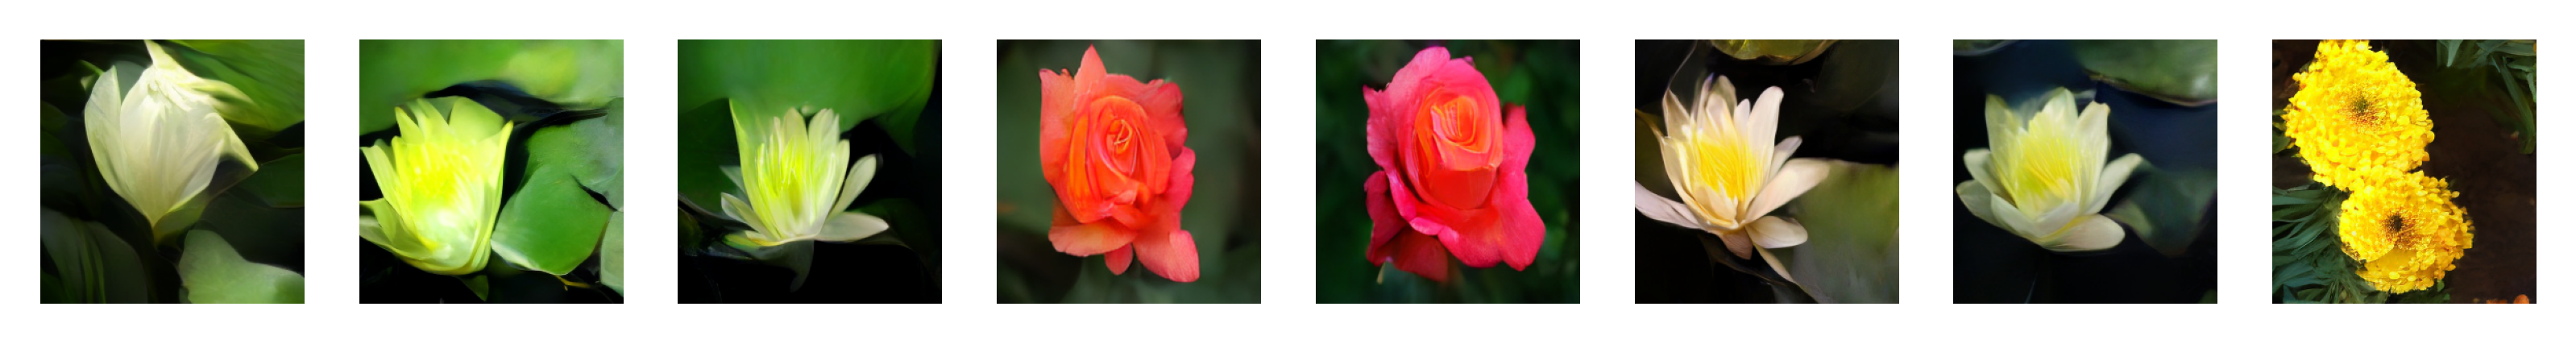

In [ ]:
plotImages(samples, dpi=500)